# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Outlier analysis](#Outlier-analysis)
* [Strata](#Strata)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Metaclassifier](#Metaclassifier)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

In this notebook, we consider whether dimensionality reduction might boost performance.

A test harness is prepared for multinomial ternary classification on FRILL embeddings. The results are visualized and discussed.

## FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Dict, List, Tuple, Sequence

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score

# preprocessing
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import OneSidedSelection

# dimensionality reduction
from sklearn.decomposition import IncrementalPCA
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# cross validator
from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# classifiers
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    RidgeClassifier,
    SGDClassifier,
)
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.03 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 127 ms


# Data loading

In [5]:
keep_columns = [
    "id",
    "source",
    "speaker_id",
    "speaker_gender",
    "emo",
    "valence",
    "neg",
    "neu",
    "lang1",
    "length",
]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")
assert all(data.index == labels.index)

time: 253 ms


In [6]:
# uncomment lines to undersample data with stratify hack
# _, _, _, labels = train_test_split(
#     data,
#     labels,
#     test_size=500,
#     random_state=SEED,
#     stratify=labels.valence,
# )
# data = data.loc[labels.index]

assert all(data.index == labels.index)
_ = gc_collect()

time: 127 ms


In [7]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 138.4 MB


,source,speaker_id,speaker_gender,emo,valence,neg,neu,lang1,length
id,,,,,,,,,
0,aesdd,aesdd.1,f,ang,0,True,False,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 17703 entries, 0 to 39247
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          17703 non-null  category
 1   speaker_id      17703 non-null  category
 2   speaker_gender  17703 non-null  category
 3   emo             17703 non-null  category
 4   valence         17703 non-null  int8    
 5   neg             17703 non-null  bool    
 6   neu             17703 non-null  bool    
 7   lang1           17703 non-null  category
 8   length          17703 non-null  category
dtypes: bool(2), category(6), int8(1)
memory usage: 356.2 KB
time: 180 ms


# Outlier analysis

Let's take a quick look at outliers. If there are many, robust PCA may be worth considering. It looks like there are few.

In [8]:
outliers = data.loc[LocalOutlierFactor(n_jobs=-1).fit_predict(data) == -1]
outliers.info()
outliers.head()
f"{100 * len(outliers)/len(data):.2f}% outliers"
del outliers
del LocalOutlierFactor

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 456 entries, 34 to 36920
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 3.6 MB


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
34,0.055215,0.014454,0.028940,0.077252,0.023877,0.040997,0.075588,0.086389,0.002560,-0.099778,...,0.014957,-0.088547,0.022753,0.003354,0.003915,-0.002987,-0.060494,0.030345,-0.021722,-0.071747
128,-0.004588,-0.095224,0.094411,0.034005,-0.103939,0.075288,0.032605,-0.096203,0.044331,0.095981,...,-0.003902,0.092879,-0.039087,0.043063,-0.024913,0.027269,-0.080965,-0.083428,0.102458,0.123120
130,-0.014580,0.009505,-0.014427,0.027941,-0.032344,0.005282,0.023033,-0.154909,-0.126070,0.181790,...,-0.019697,-0.000119,-0.066580,-0.040839,-0.046459,-0.168982,-0.217033,0.034864,-0.038831,-0.030681
156,0.012112,0.008549,0.027324,-0.092949,0.065933,0.043635,0.066915,0.023384,0.104551,-0.026314,...,-0.154226,0.022115,0.061179,0.069891,-0.194528,0.061323,-0.005765,0.029421,0.039707,-0.073807
162,0.004240,0.167605,-0.030864,-0.085685,-0.087206,0.093181,-0.023915,0.091447,-0.004889,0.142168,...,0.000916,0.023372,0.047781,0.122702,-0.003171,0.063028,-0.058641,0.005837,-0.060251,-0.015932


'2.58% outliers'

time: 26 s


# Strata

In this section, strata are set up for the train-test split.

In [9]:
N_SPLITS = 5

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 17703/17703 [00:00<00:00, 90274.27it/s]

time: 245 ms


In [10]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 119 ms


In [11]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
del strata
STRATA.value_counts()

merge passes performed: 0
only 1: 28
only 2: 19
only 3: 10
only 4: 5
merge passes performed: 1
only 1: 23
only 2: 9
only 3: 0
only 4: 0
merge passes performed: 2
only 1: 14
only 2: 0
only 3: 9
only 4: 0
merge passes performed: 3
only 1: 5
only 2: 0
only 3: 0
only 4: 9
merge passes performed: 4
only 1: 0
only 2: 0
only 3: 0
only 4: 4
merge passes performed: 5
only 1: 0
only 2: 0
only 3: 0
only 4: 0


esdfsur0cmnmedium               984
esdfang0cmnmedium               982
esdfsad0cmnmedium               736
esdmhap2cmnmedium               689
esdfhap2cmnmedium               688
                               ... 
EmoReact_V_1.0fneu1engmedium      5
BAUM1fsad0turlong                 5
stratum_group_14                  5
stratum_group_10                  5
stratum_group_11                  5
Length: 168, dtype: int64

time: 202 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [12]:
METRICS = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_geometric_mean",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", "dim_red", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    dim_red: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's score and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        "dim_red": dim_red,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"negative", "neutral", "ternary", "ternary_negneu"}

_ = gc_collect()

time: 120 ms


In [13]:
predictions_ = {key: [] for key in {"model", "case", "dim_red", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 116 ms


The cross-validation splits are pre-computed to save time in the main loops. Scaling and feature reduction for each fold are pre-computed as well.

Dimensionality reduction techniques considered include fast independent components analysis (ICA), incremental principal components analysis (PCA), and sparse random projection. Because preprocessing time is a concern, we focus on the speedier algorithms for dimensionality reduction. I actually tried PCA with a radial basis function kernel (and other algorithms) earlier and the notebook ran for over four hours before I interrupted it.

In [14]:
CV_info = namedtuple(
    "CV_info",
    _ := "X_train X_test y_train y_test",
    defaults=[None] * len(_.split()),
)
assert all(data.index == STRATA.index)
assert all(STRATA.index == labels.index)
prepared_splits = [
    *StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED).split(
        X=data, y=STRATA, groups=labels.speaker_id
    )
]

scaler = lambda: MinMaxScaler(feature_range=(-1, 1))  # preserve sign
make_adasyn = lambda strategy: ADASYN(
    sampling_strategy=strategy, random_state=SEED, n_jobs=-1
).fit_resample
DIM_RED_CHOOSER = {
    "iPCA": lambda: IncrementalPCA(whiten=True),
    "LDA": lambda: LinearDiscriminantAnalysis(),
    "SRP": lambda: SparseRandomProjection(eps=0.25, random_state=SEED),
    # eps needs to be manually set since SRP might generate too many features otherwise
}


def adasyn_upsample(X_train: Sequence, y_train: Sequence) -> Tuple[Sequence, Sequence]:
    """Upsample with ADASYN"""
    try:
        train = make_adasyn("auto")(X_train, y_train)
    except ValueError:
        try:
            train = make_adasyn("not majority")(X_train, y_train)
        except ValueError:
            try:
                train = make_adasyn("minority")(X_train, y_train)
            except ValueError:
                try:
                    train = make_adasyn("all")(X_train, y_train)
                except ValueError:
                    train = make_adasyn("not minority")(X_train, y_train)
    return train


def get_splits(case: str, resampled: bool = True, dim_red: str = "") -> List[CV_info]:
    """Prepares the three-fold cross-validation splits ternary classification."""
    splits = []
    ternary = "ternary" in case
    select_labels = labels.valence if ternary else labels.loc[:, case[:3]]
    for train_idx, test_idx in prepared_splits:
        # select and scale
        scale = scaler().fit(X_train := data.iloc[train_idx].values)
        X_train, X_test = scale.transform(X_train), scale.transform(
            data.iloc[test_idx].values
        )
        del scale
        y_train, y_test, = (
            select_labels.iloc[train_idx].values,
            select_labels.iloc[test_idx].values,
        )

        # reduce dimensions
        if dim_red:
            reducer = DIM_RED_CHOOSER[dim_red]().fit(X_train, y_train)
            X_train, X_test = reducer.transform(X_train), reducer.transform(X_test)
            del reducer

        # oversample with adasyn, undersample with oss
        if resampled:
            X_train, y_train = OneSidedSelection(
                random_state=SEED, n_jobs=-1
            ).fit_resample(*adasyn_upsample(X_train, y_train))

        splits.append(
            CV_info(
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
            )
        )
    return splits


DATA_CHOOSER: Dict[str, List[CV_info]] = {
    (case, reducer): get_splits(case, dim_red=reducer)
    for case in tqdm(ALL_CASES)
    for reducer in DIM_RED_CHOOSER.keys()
}

del scaler
_ = gc_collect()

  0%|          | 0/4 [00:00<?, ?it/s]

time: 24min 42s


# Models

Thanks to FRILL, we may now use the gamut of binary classifiers.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Class weight parameters are set to address class imbalance. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

New classifiers introduced in this notebook include BaggingClassifier, ExtraTreesClassifier, and LinearDiscriminantAnalysis.

In [15]:
MODELS = {
    "Dummy": lambda: DummyClassifier(random_state=SEED),
    "Bagging": lambda: BaggingClassifier(bootstrap_features=True),
    "ExtraTrees": lambda: ExtraTreesClassifier(
        bootstrap=True, n_jobs=-1, random_state=SEED, class_weight="balanced_subsample"
    ),
    "LDA": lambda: LinearDiscriminantAnalysis(),
    "LogReg": lambda: LogisticRegression(
        class_weight="balanced", random_state=SEED, n_jobs=-1
    ),
    "MLP": lambda: MLPClassifier(random_state=SEED),
    "PassAgg": lambda: PassiveAggressiveClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ),
    "Ridge": lambda: RidgeClassifier(class_weight="balanced", random_state=SEED),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED, class_weight="balanced"),
    "SVC": lambda: SVC(random_state=SEED, class_weight="balanced"),
}

_ = gc_collect()

time: 154 ms


# Test harness

This section defines functions for evaluating models.

In [16]:
def evaluate_model(
    model_base: str, case: str, dim_red: str, track_fold_time: bool = False
) -> AvgScores:
    """Evaluate a model with three-fold stratified grouped cross validation."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean = [], [], [], [], []
    selected_data: List[CV_info] = DATA_CHOOSER[(case, dim_red)]
    for fold_num in range(N_SPLITS):
        if track_fold_time:
            fold_begin = time()

        # obtain prepared folds
        fold_data: CV_info = selected_data[fold_num]

        # define train
        X_train = fold_data.X_train
        y_train = fold_data.y_train

        # define test
        X_test = fold_data.X_test
        y_test = fold_data.y_test

        # initialize binary model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        print(f"predicted in {end - begin:.2f} s")

        # store prediction results
        predict_times.append(end - begin)
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                dim_red=dim_red,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {"y_true": y_test, "y_pred": predicted}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )

        # free some memory
        del begin
        del end
        del model
        del predicted
        del score_params
        del X_test
        del X_train
        del y_test
        del y_train
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (balanced_accuracy, f1, geometric_mean, fit_times, predict_times)
        ]
    )


_ = gc_collect()

time: 136 ms


The next few cells evaluate models.

In [17]:
case = "negative"
for dim_red in DIM_RED_CHOOSER.keys():
    for model in tqdm(MODELS):
        loop_begin = time()
        print(f"evaluating {model}...")
        store_result(
            where=results_,
            case=case,
            model_name=model,
            dim_red=dim_red,
            avg_scores=evaluate_model(model, case, dim_red, track_fold_time=True),
        )
        print(
            f"stored {model} for {case} classification in {time() - loop_begin:.2f} s"
        )
        _ = gc_collect()

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for negative classification in 0.69 s
evaluating Bagging...
fitted in 293.46 s
predicted in 1.48 s
Bagging fold 1 completed in 294.96 s
fitted in 277.15 s
predicted in 1.42 s
Bagging fold 2 completed in 278.57 s
fitted in 291.37 s
predicted in 1.36 s
Bagging fold 3 completed in 292.75 s
fitted in 265.56 s
predicted in 1.89 s
Bagging fold 4 completed in 267.45 s
fitted in 284.27 s
predicted in 1.52 s
Bagging fold 5 completed in 285.79 s
stored Bagging for negative classification in 1420.21 s
evaluating ExtraTrees...
fitted in 4.55 s
predicted in 0.08 s
ExtraTrees fold 1 completed in 4.64 s
fitted in 4.27 s
pred

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for negative classification in 0.59 s
evaluating Bagging...
fitted in 0.16 s
predicted in 0.00 s
Bagging fold 1 completed in 0.16 s
fitted in 0.16 s
predicted in 0.01 s
Bagging fold 2 completed in 0.18 s
fitted in 0.13 s
predicted in 0.02 s
Bagging fold 3 completed in 0.15 s
fitted in 0.13 s
predicted in 0.02 s
Bagging fold 4 completed in 0.14 s
fitted in 0.17 s
predicted in 0.02 s
Bagging fold 5 completed in 0.19 s
stored Bagging for negative classification in 1.36 s
evaluating ExtraTrees...
fitted in 0.63 s
predicted in 0.06 s
ExtraTrees fold 1 completed in 0.71 s
fitted in 0.63 s
predicted in 0.06 s
ExtraTr

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for negative classification in 0.60 s
evaluating Bagging...
fitted in 203.10 s
predicted in 0.25 s
Bagging fold 1 completed in 203.35 s
fitted in 186.49 s
predicted in 0.22 s
Bagging fold 2 completed in 186.72 s
fitted in 182.76 s
predicted in 0.25 s
Bagging fold 3 completed in 183.01 s
fitted in 170.09 s
predicted in 0.30 s
Bagging fold 4 completed in 170.40 s
fitted in 230.33 s
predicted in 0.28 s
Bagging fold 5 completed in 230.61 s
stored Bagging for negative classification in 974.65 s
evaluating ExtraTrees...
fitted in 3.03 s
predicted in 0.08 s
ExtraTrees fold 1 completed in 3.11 s
fitted in 2.77 s
predi

In [18]:
case = "neutral"
for dim_red in DIM_RED_CHOOSER.keys():
    for model in tqdm(MODELS):
        loop_begin = time()
        print(f"evaluating {model}...")
        store_result(
            where=results_,
            case=case,
            model_name=model,
            dim_red=dim_red,
            avg_scores=evaluate_model(model, case, dim_red, track_fold_time=True),
        )
        print(
            f"stored {model} for {case} classification in {time() - loop_begin:.2f} s"
        )
        _ = gc_collect()

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.01 s
stored Dummy for neutral classification in 0.68 s
evaluating Bagging...
fitted in 713.39 s
predicted in 1.77 s
Bagging fold 1 completed in 715.16 s
fitted in 623.36 s
predicted in 1.58 s
Bagging fold 2 completed in 624.93 s
fitted in 678.04 s
predicted in 1.31 s
Bagging fold 3 completed in 679.36 s
fitted in 518.00 s
predicted in 1.87 s
Bagging fold 4 completed in 519.87 s
fitted in 547.07 s
predicted in 1.68 s
Bagging fold 5 completed in 548.75 s
stored Bagging for neutral classification in 3088.86 s
evaluating ExtraTrees...
fitted in 7.14 s
predicted in 0.09 s
ExtraTrees fold 1 completed in 7.23 s
fitted in 7.17 s
predic

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.01 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for neutral classification in 0.64 s
evaluating Bagging...
fitted in 0.23 s
predicted in 0.00 s
Bagging fold 1 completed in 0.24 s
fitted in 0.23 s
predicted in 0.00 s
Bagging fold 2 completed in 0.25 s
fitted in 0.23 s
predicted in 0.02 s
Bagging fold 3 completed in 0.25 s
fitted in 0.22 s
predicted in 0.01 s
Bagging fold 4 completed in 0.23 s
fitted in 0.20 s
predicted in 0.01 s
Bagging fold 5 completed in 0.21 s
stored Bagging for neutral classification in 1.74 s
evaluating ExtraTrees...
fitted in 0.78 s
predicted in 0.06 s
ExtraTrees fold 1 completed in 0.85 s
fitted in 0.82 s
predicted in 0.06 s
ExtraTree

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.00 s
fitted in 0.02 s
predicted in 0.00 s
Dummy fold 2 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for neutral classification in 0.61 s
evaluating Bagging...
fitted in 563.54 s
predicted in 0.26 s
Bagging fold 1 completed in 563.80 s
fitted in 628.87 s
predicted in 0.24 s
Bagging fold 2 completed in 629.12 s
fitted in 564.24 s
predicted in 0.24 s
Bagging fold 3 completed in 564.48 s
fitted in 516.42 s
predicted in 0.31 s
Bagging fold 4 completed in 516.74 s
fitted in 631.21 s
predicted in 0.30 s
Bagging fold 5 completed in 631.52 s
stored Bagging for neutral classification in 2906.24 s
evaluating ExtraTrees...
fitted in 5.36 s
predicted in 0.14 s
ExtraTrees fold 1 completed in 5.50 s
fitted in 5.70 s
predic

In [19]:
case = "ternary"
for dim_red in DIM_RED_CHOOSER.keys():
    for model in tqdm(MODELS):
        loop_begin = time()
        print(f"evaluating {model}...")
        store_result(
            where=results_,
            case=case,
            model_name=model,
            dim_red=dim_red,
            avg_scores=evaluate_model(model, case, dim_red, track_fold_time=True),
        )
        print(
            f"stored {model} for {case} classification in {time() - loop_begin:.2f} s"
        )
        _ = gc_collect()

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.00 s
fitted in 0.00 s
predicted in 0.02 s
Dummy fold 3 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.00 s
stored Dummy for ternary classification in 0.61 s
evaluating Bagging...
fitted in 476.38 s
predicted in 1.52 s
Bagging fold 1 completed in 477.91 s
fitted in 434.94 s
predicted in 1.39 s
Bagging fold 2 completed in 436.34 s
fitted in 451.74 s
predicted in 1.34 s
Bagging fold 3 completed in 453.10 s
fitted in 401.34 s
predicted in 2.25 s
Bagging fold 4 completed in 403.59 s
fitted in 498.88 s
predicted in 2.02 s
Bagging fold 5 completed in 500.91 s
stored Bagging for ternary classification in 2272.40 s
evaluating ExtraTrees...
fitted in 6.06 s
predicted in 0.09 s
ExtraTrees fold 1 completed in 6.16 s
fitted in 5.77 s
predic

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.02 s
predicted in 0.00 s
Dummy fold 1 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.02 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.00 s
fitted in 0.02 s
predicted in 0.00 s
Dummy fold 5 completed in 0.02 s
stored Dummy for ternary classification in 0.61 s
evaluating Bagging...
fitted in 0.48 s
predicted in 0.00 s
Bagging fold 1 completed in 0.50 s
fitted in 0.45 s
predicted in 0.02 s
Bagging fold 2 completed in 0.47 s
fitted in 0.47 s
predicted in 0.00 s
Bagging fold 3 completed in 0.48 s
fitted in 0.37 s
predicted in 0.02 s
Bagging fold 4 completed in 0.39 s
fitted in 0.41 s
predicted in 0.02 s
Bagging fold 5 completed in 0.42 s
stored Bagging for ternary classification in 2.78 s
evaluating ExtraTrees...
fitted in 0.84 s
predicted in 0.06 s
ExtraTrees fold 1 completed in 0.92 s
fitted in 0.84 s
predicted in 0.06 s
ExtraTree

  0%|          | 0/10 [00:00<?, ?it/s]

evaluating Dummy...
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 1 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 2 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 3 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 4 completed in 0.00 s
fitted in 0.00 s
predicted in 0.00 s
Dummy fold 5 completed in 0.02 s
stored Dummy for ternary classification in 0.60 s
evaluating Bagging...
fitted in 344.66 s
predicted in 0.34 s
Bagging fold 1 completed in 345.00 s
fitted in 357.86 s
predicted in 0.37 s
Bagging fold 2 completed in 358.25 s
fitted in 331.87 s
predicted in 0.44 s
Bagging fold 3 completed in 332.31 s
fitted in 326.11 s
predicted in 0.39 s
Bagging fold 4 completed in 326.50 s
fitted in 342.88 s
predicted in 0.33 s
Bagging fold 5 completed in 343.21 s
stored Bagging for ternary classification in 1705.80 s
evaluating ExtraTrees...
fitted in 5.06 s
predicted in 0.09 s
ExtraTrees fold 1 completed in 5.16 s
fitted in 4.70 s
predic

Let's peek at the results.

In [20]:
results_df = (
    pd.DataFrame(results_)
    .sort_values(by=["case", "dim_red", "model_name"])
    .reset_index(drop=True)
)
results_df

,avg_cv_balanced_accuracy,case,dim_red,avg_cv_geometric_mean,avg_cv_f1,avg_cv_fit_time,model_name,avg_cv_predict_time
0,0.615492,negative,LDA,0.611685,0.614472,0.149399,Bagging,0.011163
1,0.500000,negative,LDA,0.000000,0.281249,0.000000,Dummy,0.000000
2,0.618183,negative,LDA,0.614891,0.618753,0.626815,ExtraTrees,0.060378
3,0.638083,negative,LDA,0.635275,0.639918,0.009372,LDA,0.000000
4,0.637512,negative,LDA,0.634773,0.638964,0.021866,LogReg,0.000000
...,...,...,...,...,...,...,...,...
85,0.525121,ternary,iPCA,0.489882,0.575953,44.221821,MLP,0.025005
86,0.530961,ternary,iPCA,0.515786,0.564035,6.087926,PassAgg,0.009357
87,0.544792,ternary,iPCA,0.525283,0.571665,1.703202,Ridge,0.012502
88,0.518687,ternary,iPCA,0.498544,0.565996,17.728695,SGD,0.015619


time: 63.2 ms


# Metaclassifier

After the binary classifiers are evaluated, the metaclassifiers are evaluated based on the binary predictions. The metaclassifiers' fit and score times are estimated by summing the fit and score times of the base estimators.

In [21]:
# set up the "metaclassifier"

case = "ternary_negneu"
ternary_hybrid_ytest: Dict[str, List[pd.Series]] = {
    reducer: [DATA_CHOOSER[(case, reducer)][fold].y_test for fold in range(N_SPLITS)]
    for reducer in DIM_RED_CHOOSER.keys()
}
# list indexed by fold

# convenience function
get_time = lambda case, model_name, metric: results_df.query(
    f"case == '{case}' & model_name == '{model_name}'"
)[metric].values[0]

predictions_df = pd.DataFrame(predictions_)

for reducer in DIM_RED_CHOOSER.keys():
    pred_df = predictions_df.query(f"dim_red == '{reducer}'").drop(columns="dim_red")
    for neutral_model in tqdm(MODELS.keys()):
        for negative_model in MODELS.keys():
            balanced_accuracy, f1, geometric_mean = [], [], []
            model_combo = f"{neutral_model}+{negative_model}"
            for fold_num in range(N_SPLITS):

                # ensemble
                fold_df = pred_df.query(f"fold == {fold_num}").drop(columns="fold")
                neutral_condition = f"case == 'neutral' & model == '{neutral_model}'"
                negative_condition = f"case == 'negative' & model == '{negative_model}'"
                query_fold = lambda criteria: fold_df.query(criteria).y_pred.item()
                df = pd.DataFrame(
                    {
                        "neutral_prediction": query_fold(neutral_condition),
                        "negative_prediction": query_fold(negative_condition),
                    }
                )
                del fold_df
                del negative_condition
                del neutral_condition
                del query_fold

                # "predict" 0: negative, 1: neutral, 2: positive
                df["hybrid_prediction"] = df.neutral_prediction.replace(True, 1)
                df.loc[df["hybrid_prediction"] == False, "hybrid_prediction"] = df.loc[
                    df["hybrid_prediction"] == False, "negative_prediction"
                ].replace([True, False], [0, 2])
                y_pred = df.hybrid_prediction.astype(np.int8)
                del df

                # record y_pred
                store_prediction(
                    where=predictions_,
                    prediction=Prediction(
                        model=model_combo,
                        case="ternary_negneu",
                        dim_red=reducer,
                        fold=fold_num,
                        y_pred=y_pred,
                    ),
                )

                # score
                score_params = {
                    "y_true": ternary_hybrid_ytest[reducer][fold_num],
                    "y_pred": y_pred,
                }
                balanced_accuracy.append(balanced_accuracy_score(**score_params))
                f1.append(f1_score(**score_params, average="weighted"))
                geometric_mean.append(geometric_mean_score(**score_params))
                del score_params
                del y_pred

                _ = gc_collect()

            # convenience function
            sum_times = lambda time_metric: get_time(
                "neutral", neutral_model, time_metric
            ) + get_time("negative", negative_model, time_metric)

            store_result(
                where=results_,
                case="ternary_negneu",
                model_name=model_combo,
                dim_red=reducer,
                avg_scores=AvgScores(
                    np.mean(balanced_accuracy),
                    np.mean(f1),
                    np.mean(geometric_mean),
                    sum_times("avg_cv_fit_time"),
                    sum_times("avg_cv_predict_time"),
                ),
            )

            print(f"stored hybrid ternary classification results for {model_combo}")

            del balanced_accuracy
            del f1
            del geometric_mean
            del model_combo
            _ = gc_collect()
    del pred_df
    _ = gc_collect()

# re-define predictions_df since it has been modified
predictions_df = pd.DataFrame(predictions_)

  0%|          | 0/10 [00:00<?, ?it/s]

stored hybrid ternary classification results for Dummy+Dummy
stored hybrid ternary classification results for Dummy+Bagging
stored hybrid ternary classification results for Dummy+ExtraTrees
stored hybrid ternary classification results for Dummy+LDA
stored hybrid ternary classification results for Dummy+LogReg
stored hybrid ternary classification results for Dummy+MLP
stored hybrid ternary classification results for Dummy+PassAgg
stored hybrid ternary classification results for Dummy+Ridge
stored hybrid ternary classification results for Dummy+SGD
stored hybrid ternary classification results for Dummy+SVC
stored hybrid ternary classification results for Bagging+Dummy
stored hybrid ternary classification results for Bagging+Bagging
stored hybrid ternary classification results for Bagging+ExtraTrees
stored hybrid ternary classification results for Bagging+LDA
stored hybrid ternary classification results for Bagging+LogReg
stored hybrid ternary classification results for Bagging+MLP
stored

  0%|          | 0/10 [00:00<?, ?it/s]

stored hybrid ternary classification results for Dummy+Dummy
stored hybrid ternary classification results for Dummy+Bagging
stored hybrid ternary classification results for Dummy+ExtraTrees
stored hybrid ternary classification results for Dummy+LDA
stored hybrid ternary classification results for Dummy+LogReg
stored hybrid ternary classification results for Dummy+MLP
stored hybrid ternary classification results for Dummy+PassAgg
stored hybrid ternary classification results for Dummy+Ridge
stored hybrid ternary classification results for Dummy+SGD
stored hybrid ternary classification results for Dummy+SVC
stored hybrid ternary classification results for Bagging+Dummy
stored hybrid ternary classification results for Bagging+Bagging
stored hybrid ternary classification results for Bagging+ExtraTrees
stored hybrid ternary classification results for Bagging+LDA
stored hybrid ternary classification results for Bagging+LogReg
stored hybrid ternary classification results for Bagging+MLP
stored

  0%|          | 0/10 [00:00<?, ?it/s]

stored hybrid ternary classification results for Dummy+Dummy
stored hybrid ternary classification results for Dummy+Bagging
stored hybrid ternary classification results for Dummy+ExtraTrees
stored hybrid ternary classification results for Dummy+LDA
stored hybrid ternary classification results for Dummy+LogReg
stored hybrid ternary classification results for Dummy+MLP
stored hybrid ternary classification results for Dummy+PassAgg
stored hybrid ternary classification results for Dummy+Ridge
stored hybrid ternary classification results for Dummy+SGD
stored hybrid ternary classification results for Dummy+SVC
stored hybrid ternary classification results for Bagging+Dummy
stored hybrid ternary classification results for Bagging+Bagging
stored hybrid ternary classification results for Bagging+ExtraTrees
stored hybrid ternary classification results for Bagging+LDA
stored hybrid ternary classification results for Bagging+LogReg
stored hybrid ternary classification results for Bagging+MLP
stored

Let's peek at the results.

In [22]:
results_df = (
    pd.DataFrame(results_)
    .sort_values(by=["case", "dim_red", "model_name"])
    .reset_index(drop=True)
)
results_df

,avg_cv_balanced_accuracy,case,dim_red,avg_cv_geometric_mean,avg_cv_f1,avg_cv_fit_time,model_name,avg_cv_predict_time
0,0.615492,negative,LDA,0.611685,0.614472,0.149399,Bagging,0.011163
1,0.500000,negative,LDA,0.000000,0.281249,0.000000,Dummy,0.000000
2,0.618183,negative,LDA,0.614891,0.618753,0.626815,ExtraTrees,0.060378
3,0.638083,negative,LDA,0.635275,0.639918,0.009372,LDA,0.000000
4,0.637512,negative,LDA,0.634773,0.638964,0.021866,LogReg,0.000000
...,...,...,...,...,...,...,...,...
385,0.459979,ternary_negneu,iPCA,0.383173,0.527631,4.012872,SVC+MLP,0.034379
386,0.432321,ternary_negneu,iPCA,0.365919,0.495370,2.522097,SVC+PassAgg,0.025005
387,0.459586,ternary_negneu,iPCA,0.383923,0.523583,2.534586,SVC+Ridge,0.025005
388,0.446031,ternary_negneu,iPCA,0.375897,0.508225,2.537715,SVC+SGD,0.025005


time: 21.9 ms


# Results

In this section, we create several visualizations to display the results.

Note that the charts depicting fit and predict times do not account for the dimensionality reduction step.

In [23]:
metric_names = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_geometric_mean": "geometric mean",
    "avg_cv_predict_time": "predict time",
}

_ = gc_collect()

time: 107 ms


In [24]:
def plot_binary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[~results_df.model_name.str.contains("Dummy")]

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="dim_red",
        data=results_df,
        col="case",
        hue_order=DIM_RED_CHOOSER.keys(),
        col_order=["neutral", "negative"],
        seed=SEED,
        kind="bar",
        palette=dict(
            zip(
                _ := np.unique(results_df.dim_red),
                sns.color_palette(palette="colorblind", n_colors=len(_)),
            )
        ),
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=3,
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{metric_names[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 115 ms


  0%|          | 0/5 [00:00<?, ?it/s]

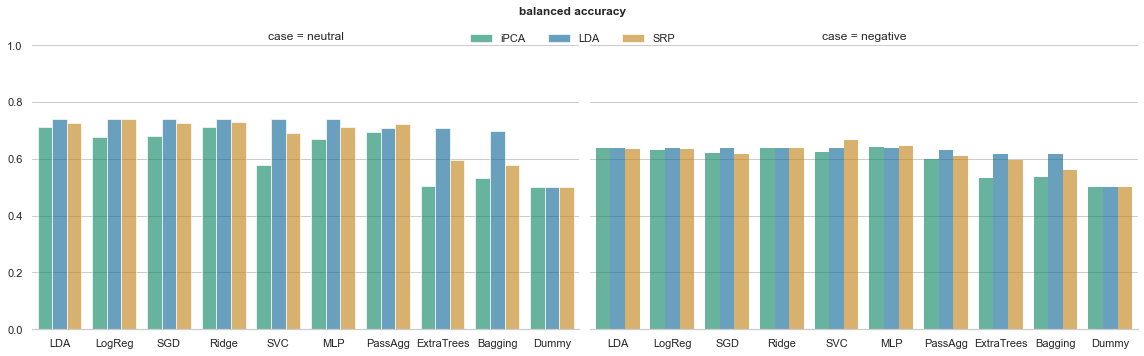

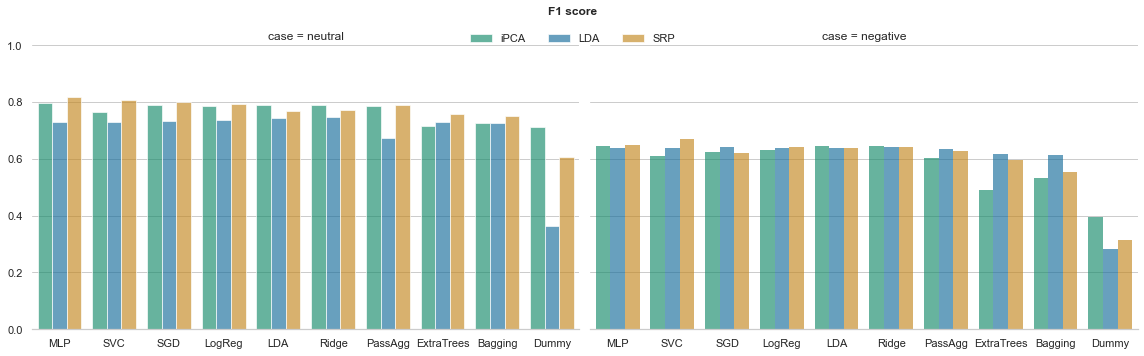

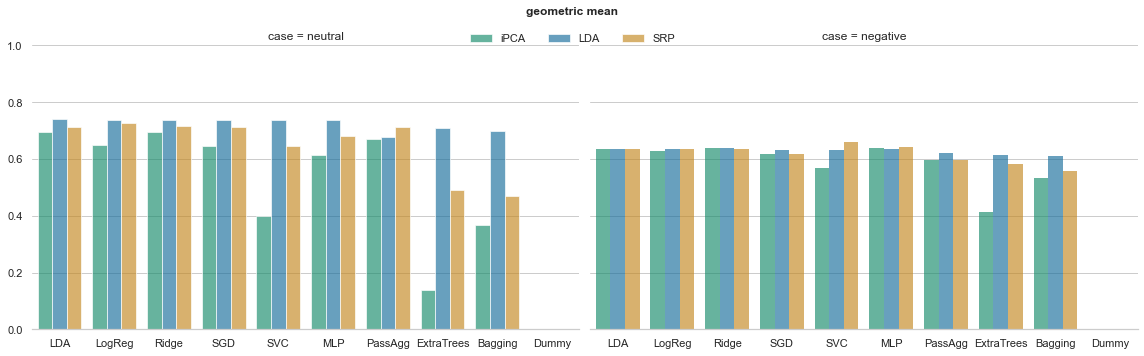

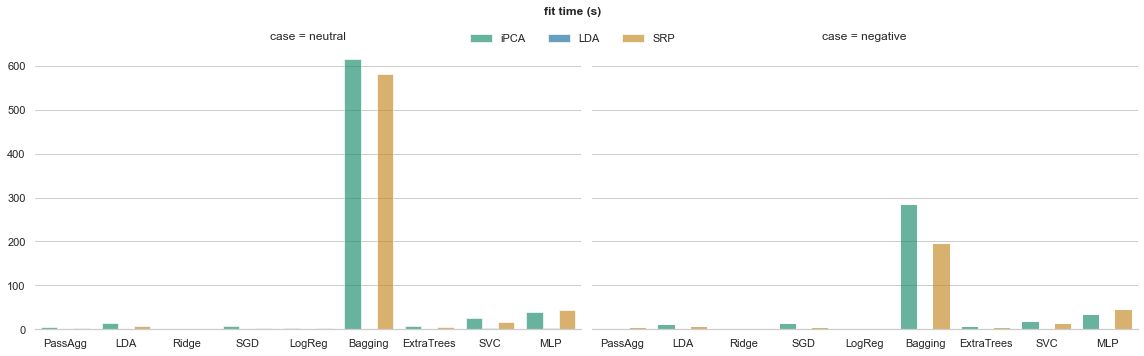

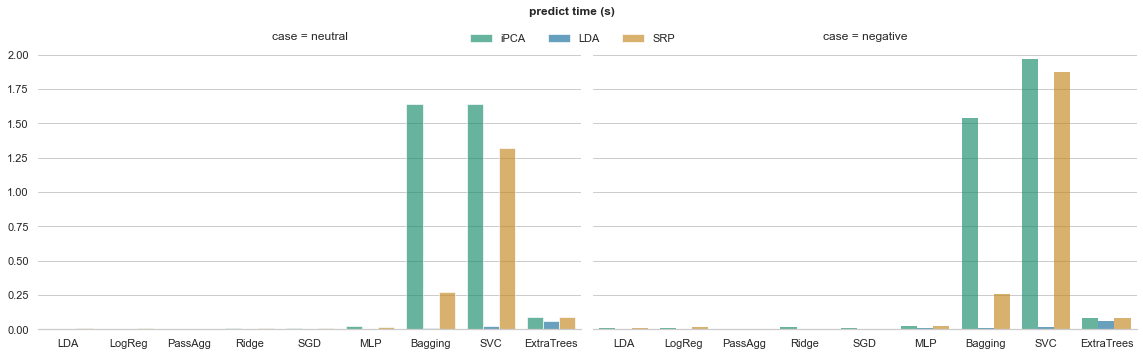

time: 4.68 s


In [25]:
for metric in tqdm(METRICS):
    plot_binary_metric(metric, results_df.loc[~results_df.case.str.contains("ternary")])

In [26]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    results_df.loc[:, "model_name"] = results_df.loc[:, "model_name"].str.cat(
        results_df.loc[:, "dim_red"], sep="+"
    )
    if time_metric:
        # When plotting fit/predict times, the pure dummy classifiers are omitted since it is always the fastest.
        results_df = results_df.loc[
            ~results_df.model_name.isin(("Dummy", "Dummy+Dummy"))
        ]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(10)
    g.fig.set_figheight(50)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(
        f"{metric_names[metric]}{' (s)' if time_metric else ''}", y=1, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 147 ms


  0%|          | 0/5 [00:00<?, ?it/s]

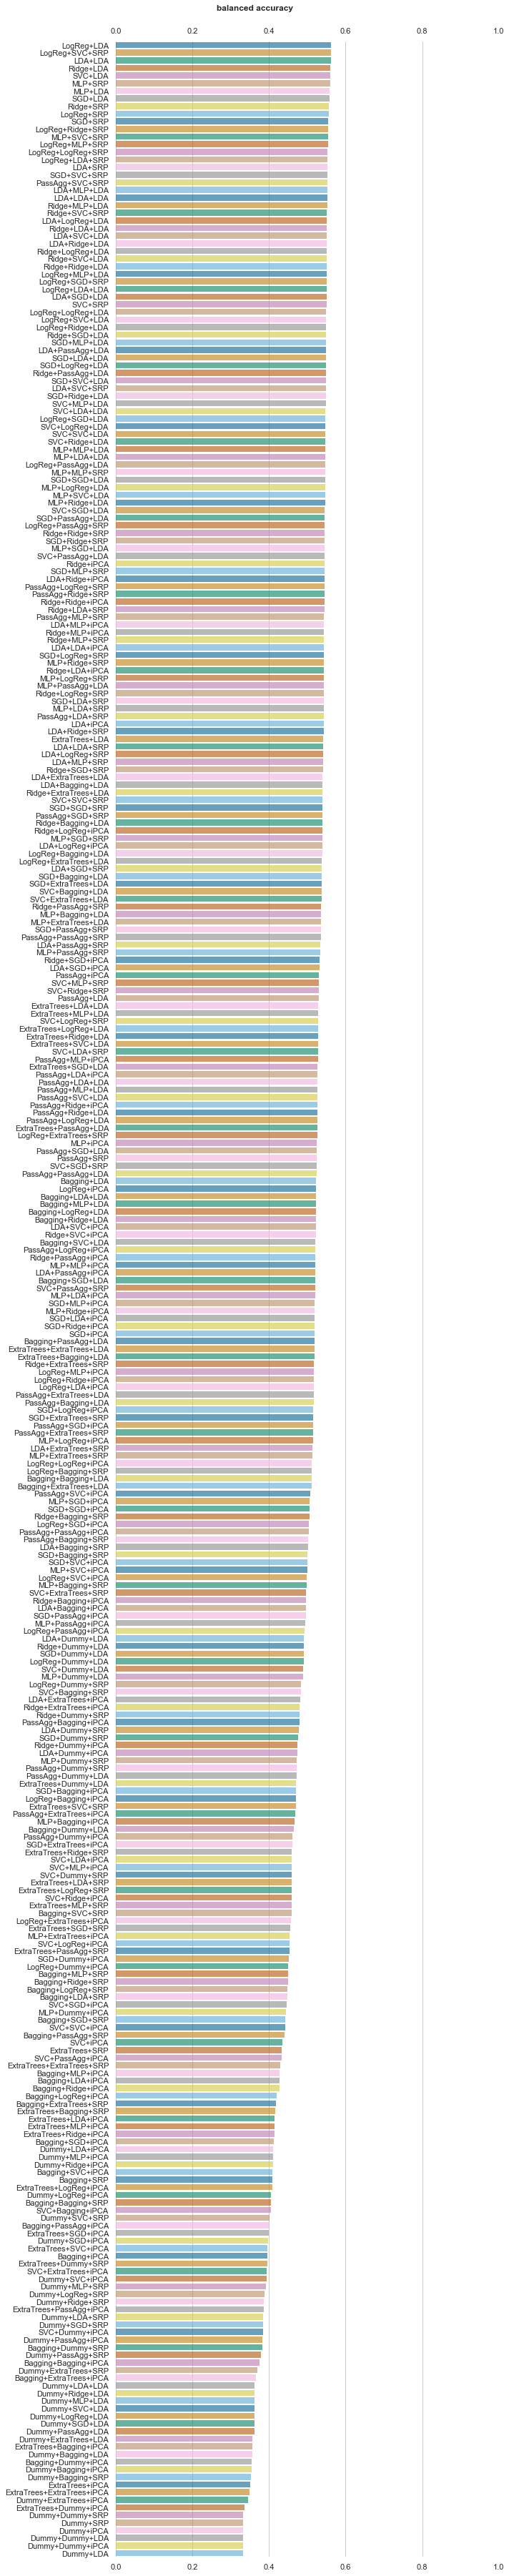

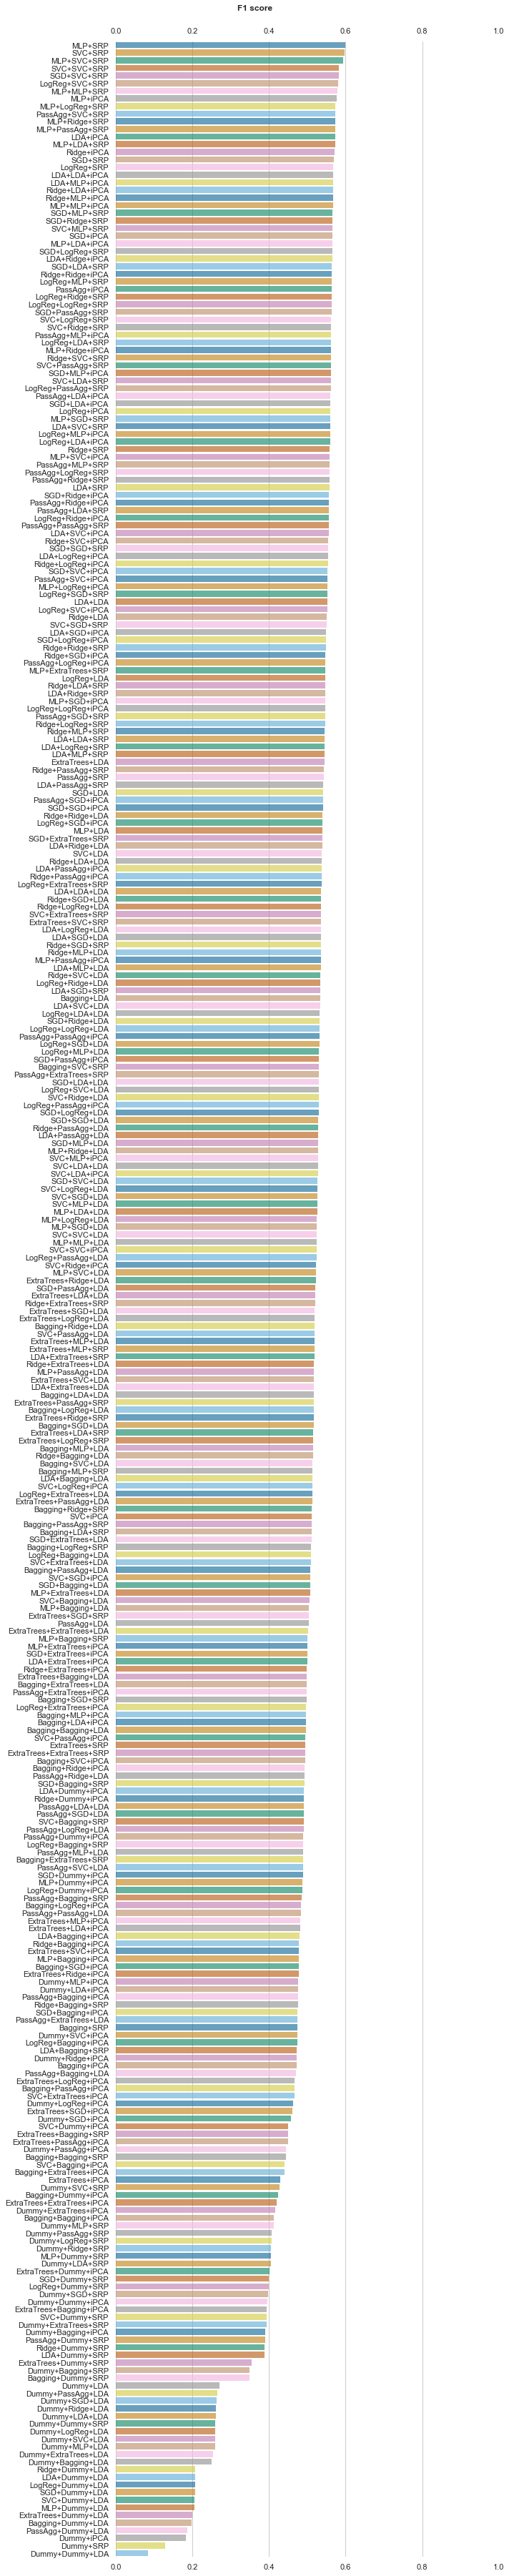

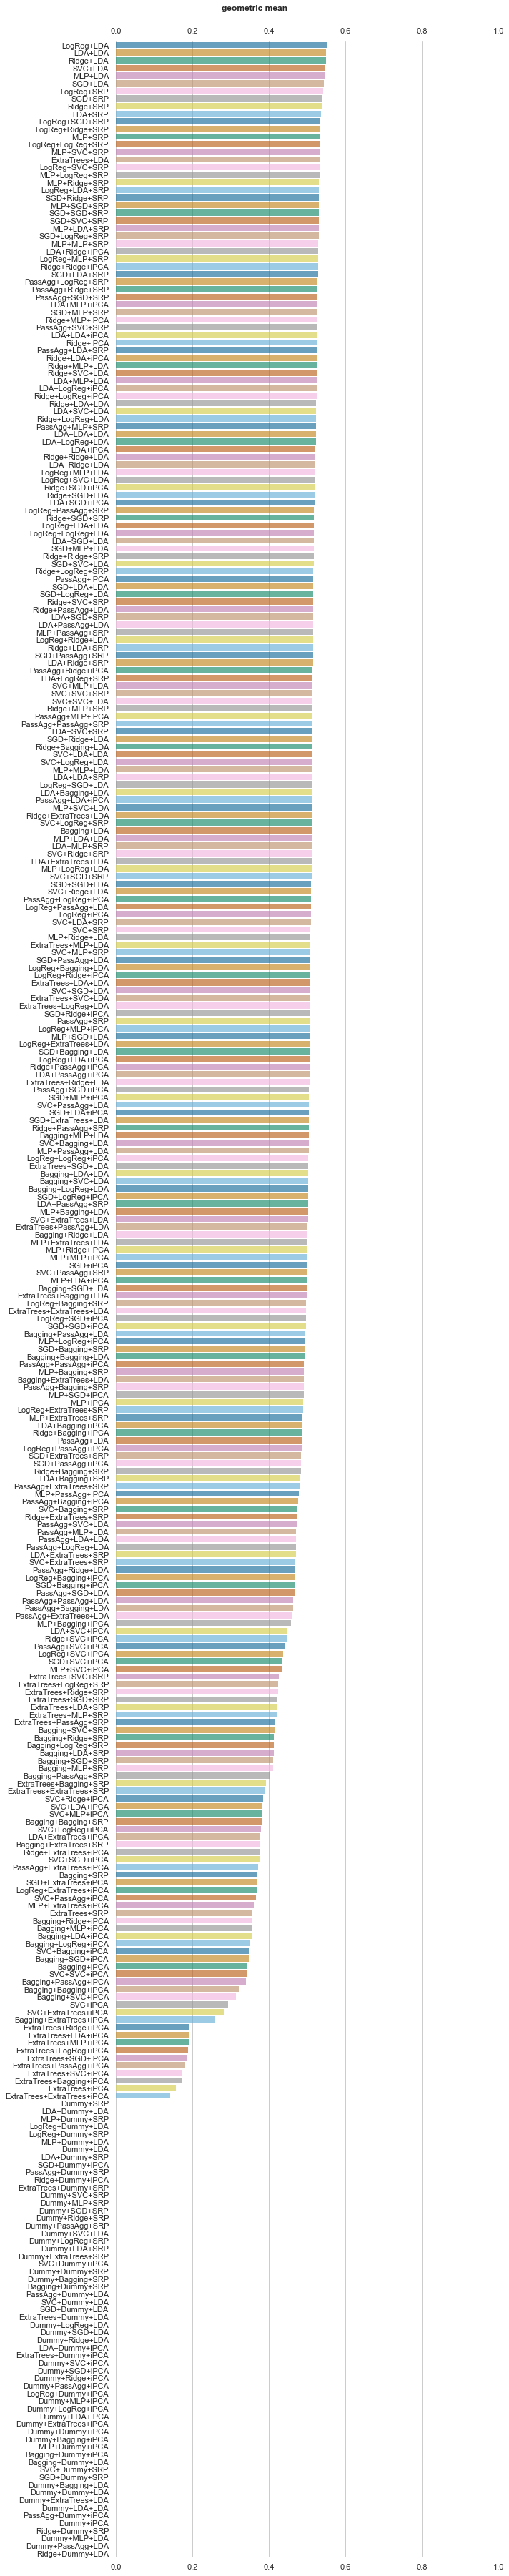

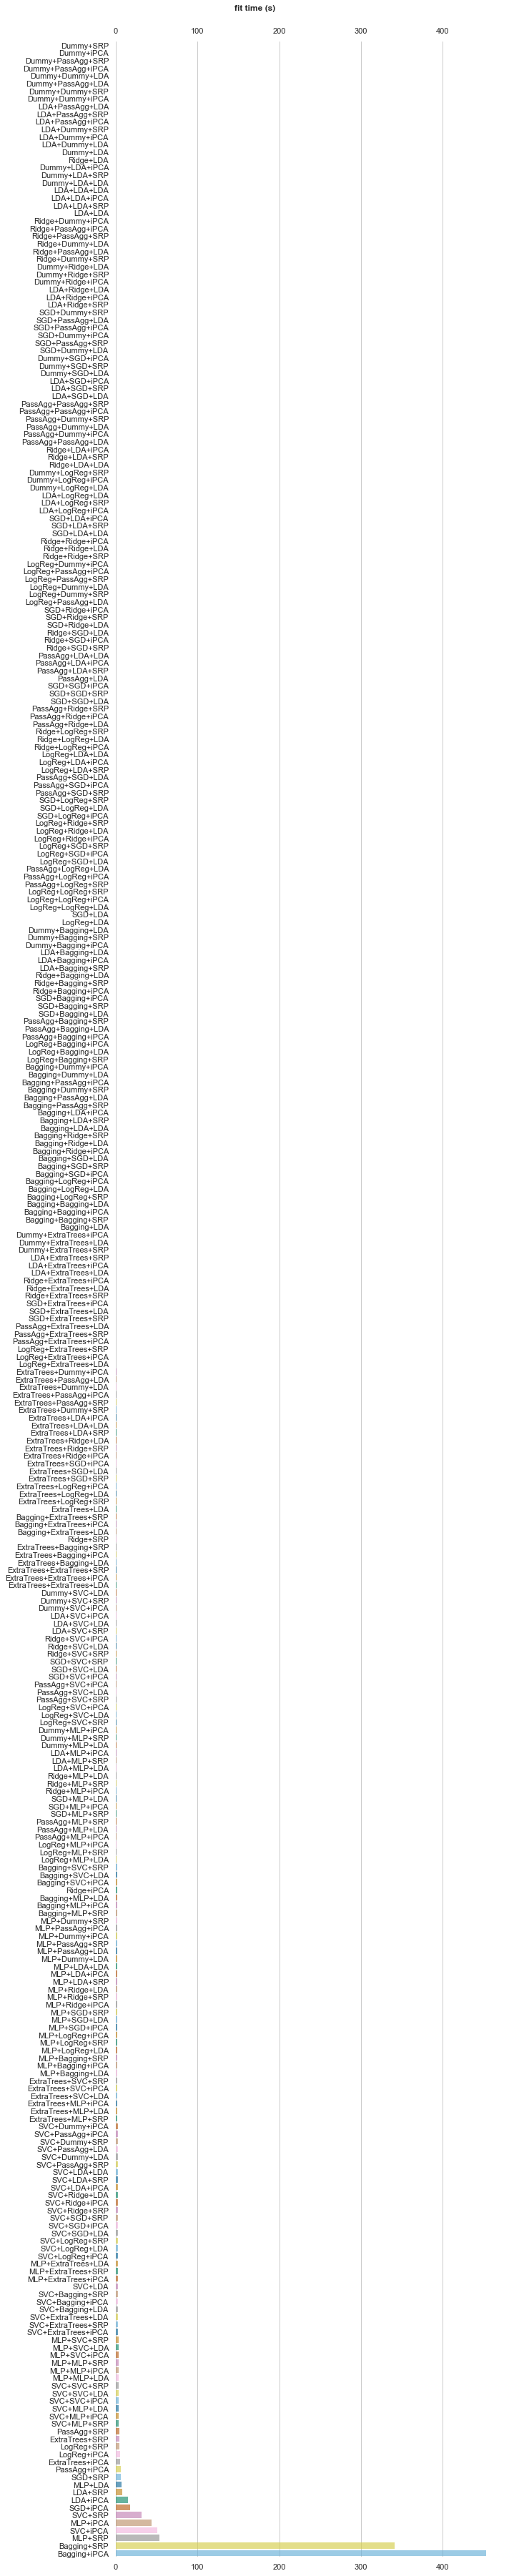

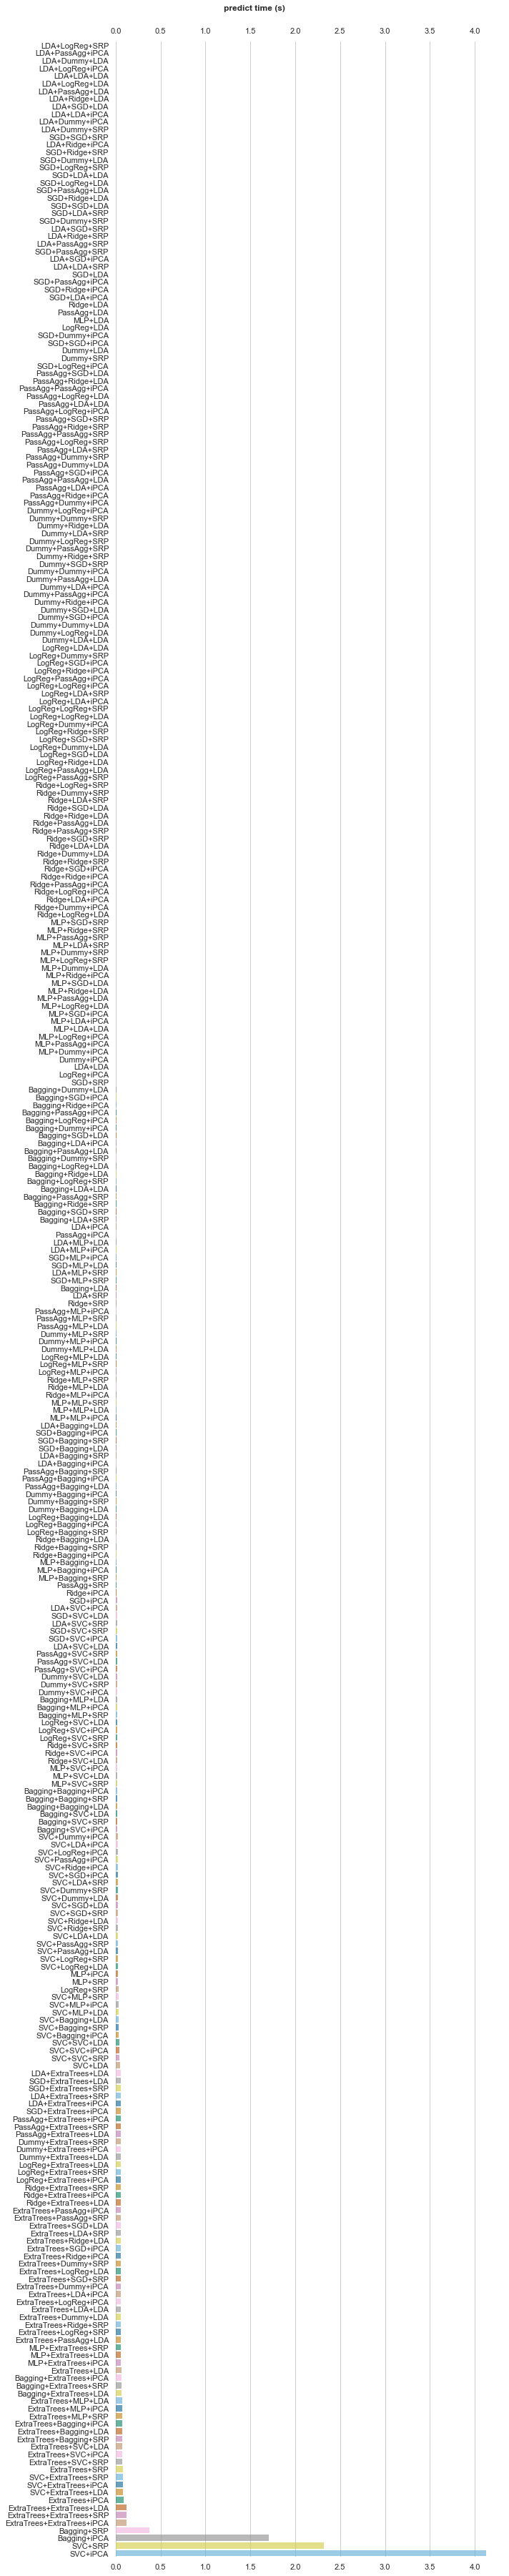

time: 38.4 s


In [27]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df.loc[results_df.case.str.contains("ternary")])

In [28]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/explore_dimred_neg-neu_hybrid_results_CV{N_SPLITS}.csv")

time: 18.8 ms


# Discussion

The plots reveal that models are sensitive to the configuration of dimensionality reduction; models perform better or worse depending on which method was used. Generally, incremental PCA resulted in the worst performance.

In a separate notebook, we will plot these results with those previously obtained without dimensionality reduction to assess whether dimensionality reduction boosted performance globally as well.

In [29]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 17423.620396137238 s
time: 148 ms


[^top](#Contents)